# モデルの中身を覗く

変数の重要度の取得方法とPDPの作図法を学びます。PDPは変数の重要度トップNについて作成しています。<br>以下２つの関数を利用し、データはビッグマートのデータ（店舗×商品別の売上金額が目的変数）を用いています。
1. get_feature_importances：変数の重要度を返す関数
1. get_top_N_features：変数の重要度トップNの変数を返す関数

C:\Users\hiroa\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,0
Item_Weight,0.077669
Item_Visibility,0.134454
Item_MRP,0.445133
Outlet_Establishment_Year,0.049862
Item_Fat_Content_LF,0.000000
Item_Fat_Content_Low Fat,0.000000
Item_Fat_Content_Regular,0.001982
Item_Fat_Content_low fat,0.000000
Item_Fat_Content_reg,0.005557
Item_Fat_Content_nan,0.000000


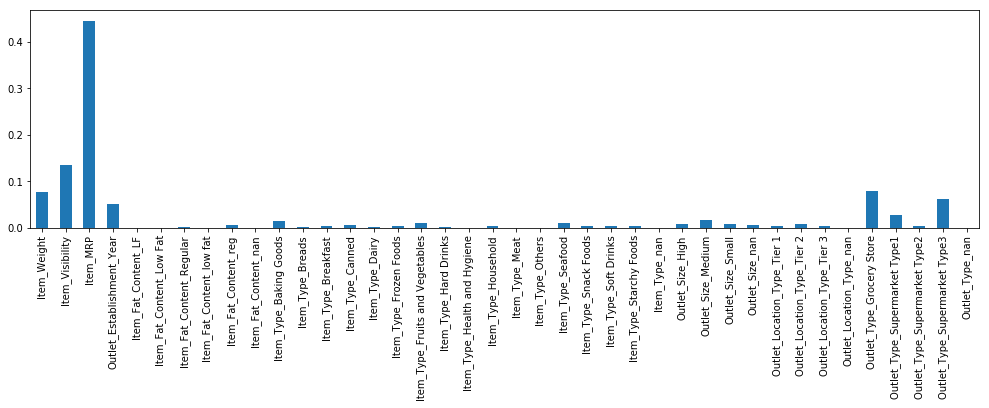

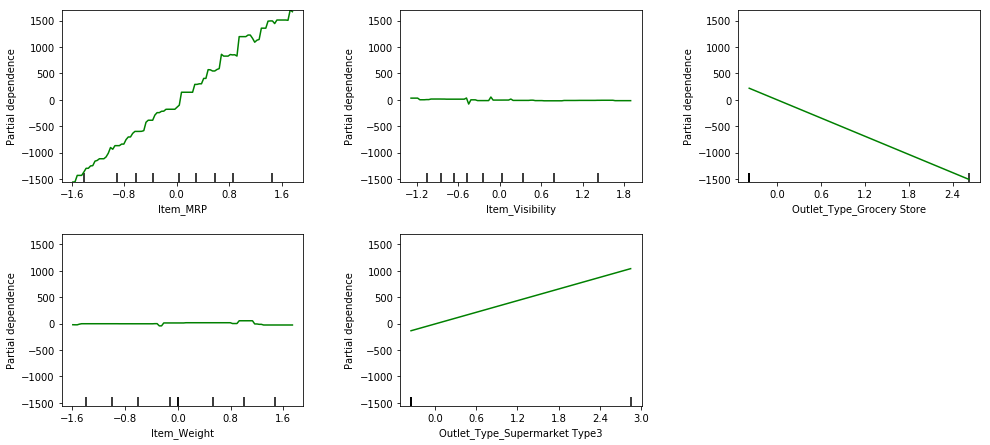

In [2]:
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

def main():
    # import data
    df = pd.read_csv('./data/av_big_mart_sales_UWu5bXk.csv',header=0)
    X  = df.drop(['Outlet_Identifier','Item_Identifier','Item_Outlet_Sales'],axis=1)
    y  = df.loc[:, ['Item_Outlet_Sales']]

    # 日付データ処理
    CDATE = 2013
    X.loc[:,['Outlet_Establishment_Year']] = \
        CDATE - X.loc[:,['Outlet_Establishment_Year']]

    # one-hot エンコーディング
    ohe_columns = ['Item_Fat_Content',
                   'Item_Type',
                   'Outlet_Size',
                   'Outlet_Location_Type',
                   'Outlet_Type']
    X_ohe = pd.get_dummies(X,
                           dummy_na=True,
                           columns=ohe_columns)

    # 欠損値補完(平均値置換,処理は列方向)
    imp = Imputer(missing_values='NaN',
                  strategy='mean',
                  axis=0)
    imp.fit(X_ohe)

    X_ohe_columns = X_ohe.columns.values
    X_ohe = pd.DataFrame(imp.transform(X_ohe),
                         columns=X_ohe_columns)
    # モデル構築
    pipe_gbr = Pipeline([('scl',StandardScaler()),
                         ('est',GradientBoostingRegressor(random_state=1))])
    pipe_gbr.fit(X_ohe,
                 y.as_matrix().ravel())

    ##################################################
    # 変数の重要度
    ##################################################
    df_imp = get_feature_importances(pipe_gbr,
                                     X_ohe_columns)
    df_imp.T.plot(kind='bar',
                  figsize=(17,4),
                  legend=False)
    display(df_imp.T)
    
    ##################################################
    # Partial Dependence
    ##################################################
    est = pipe_gbr.named_steps['est']
    scl = pipe_gbr.named_steps['scl']
    N=5
    df_top_N = get_top_N_features(pipe_gbr,
                                  X_ohe_columns,
                                  N)
    fig,axs= plot_partial_dependence(est,
                                     scl.transform(X_ohe),
                                     features=df_top_N.index.tolist(),
                                     feature_names=X_ohe_columns)
    mpl.pyplot.show()

def get_feature_importances(pipeline, columns):
    # 変数の重要度はfeature_importances_で取得
    imp = pipeline.named_steps['est'].feature_importances_
    return pd.DataFrame([imp], columns=columns)

def get_top_N_features(pipeline, columns, N):
    # 変数の重要度Top-Nの取得
    df_imp=pd.DataFrame(get_feature_importances(pipeline,columns),
                        columns=columns).T.rank(method='min',ascending=False)
    #display(df_imp)
    return df_imp.where(df_imp[0]<=N).reset_index().dropna().sort_values(by=0)

if __name__ == '__main__':
    main()